In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('https://raw.githubusercontent.com/AMoazeni/Machine-Learning-Stock-Market-Prediction/master/Data/Google_Stock_Price_Train.csv')
# '.values' need the 2nd Column Opening Price as a Numpy array (not vector)
# '1:2' is used because the upper bound is ignored
training_set = dataset_train.iloc[:, 1:2].values

# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Show the dataset we're working with
display(dataset_train)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 1))

# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 6s 42ms/step - loss: 0.0516
Epoch 2/100
38/38 [==============================] - 2s 43ms/step - loss: 0.0067
Epoch 3/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0058
Epoch 4/100
38/38 [==============================] - 2s 43ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 2s 51ms/step - loss: 0.0055
Epoch 6/100
38/38 [==============================] - 2s 45ms/step - loss: 0.0057
Epoch 7/100
38/38 [==============================] - 2s 48ms/step - loss: 0.0048
Epoch 8/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0045
Epoch 9/100
38/38 [==============================] - 2s 44ms/step - loss: 0.0041
Epoch 10/100
38/38 [==============================] - 2s 65ms/step - loss: 0.0037
Epoch 11/100
38/38 [==============================] - 3s 70ms/step - loss: 0.0040
Epoch 12/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0039
Epoch 13/100
38/38 [=====

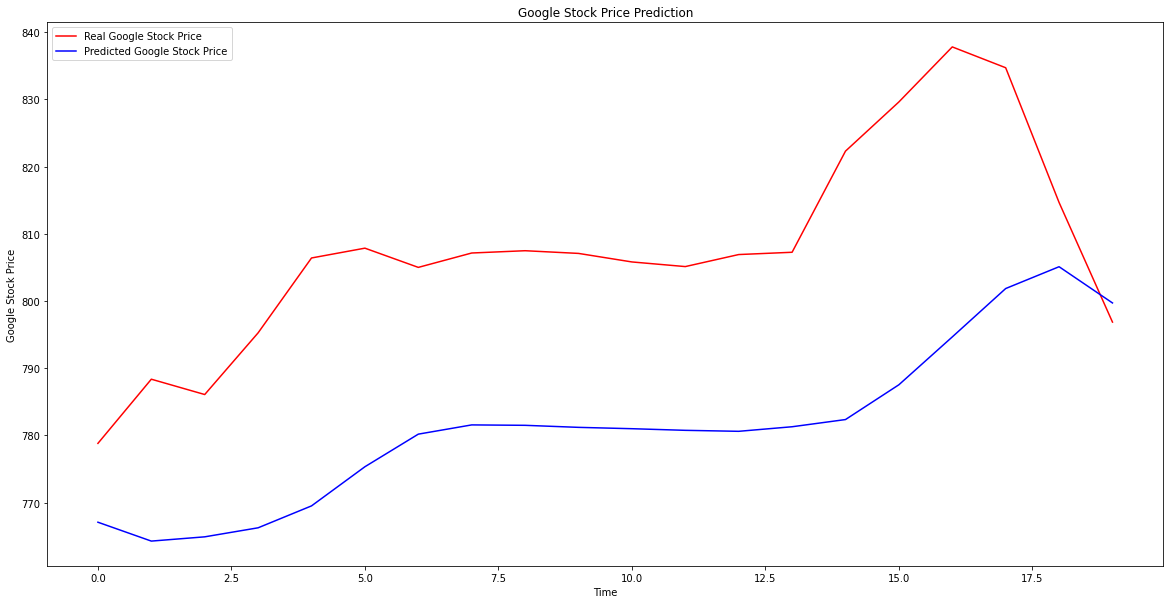

In [9]:
dataset_test = pd.read_csv('https://raw.githubusercontent.com/AMoazeni/Machine-Learning-Stock-Market-Prediction/master/Data/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
# We need 60 previous inputs for each day of the Test_set in 2017
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# Extract Stock Prices for Test time period, plus 60 days previous
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# 'reshape' function to get it into a NumPy format
inputs = inputs.reshape(-1,1)
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs = sc.transform(inputs)
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()